<a href="https://colab.research.google.com/github/kappakpr/kaggle_paddydoctor/blob/main/paddydoctor_multimodel_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check if the dataset is imbalanced ??

In [116]:
!nvidia-smi

Thu Oct 31 06:56:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |   9231MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [117]:
competition_name = "paddy-disease-classification"

In [118]:
!pip install mlflow --quiet
!pip install pyngrok --quiet


Read the MLFlow authentication tokens from colab secrets

In [119]:
import mlflow, os
from pyngrok import ngrok
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import userdata
    os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
    os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
else:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    os.environ['MLFLOW_TRACKING_USERNAME'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
    os.environ['MLFLOW_TRACKING_PASSWORD'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'PADDYDOCTOR'

Start the MLFlow service in background on port 5000 for run logging in MLFlow

In [120]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")# run tracking UI in the background

Using ngrok connect MLFLow local service URL to internet

In [121]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml


In [122]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
if os.getenv("COLAB_RELEASE_TAG"):
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
else:
    NGROK_AUTH_TOKEN = user_secrets.get_secret("NGROK_AUTH_TOKEN")
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Check if a tunnel is already running before starting a new one
active_tunnels = ngrok.get_tunnels()
active_tunnels
if not active_tunnels:
    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    public_url = ngrok.connect(5000, name='MLFLow URL')
    print("MLflow Tracking UI:", public_url)
else:
    print("An ngrok tunnel is already running:", active_tunnels[0].public_url)
    public_url = active_tunnels[0].public_url # Use the existing tunnel's URL

MLflow Tracking UI: NgrokTunnel: "https://872e-34-125-1-132.ngrok-free.app" -> "http://localhost:5000"


In [123]:
# Cleanup function
def cleanup():
    # Close MLflow run if any is active
    try:
        mlflow.end_run()
    except:
        pass

    # Disconnect ngrok
    try:
        ngrok.disconnect(listener.url())
        ngrok.kill()  # Kill the ngrok process
    except:
        pass

    # Kill MLflow server (optional, if you want to completely shut down the server)
    !pkill -f "mlflow server"

Invoke cleanup at the end to stop MLFlow logging

In [124]:
# Create a new experiment
try:
    experiment = mlflow.create_experiment('convnext_tiny')
except mlflow.exceptions.MlflowException as e:
    # If experiment already exists, get its ID
    experiment = mlflow.get_experiment_by_name('convnext_tiny').experiment_id

# Set the experiment
mlflow.set_experiment('convnext_tiny')

<Experiment: artifact_location='file:///content/mlruns/472726004553128280', creation_time=1730352749703, experiment_id='472726004553128280', last_update_time=1730352749703, lifecycle_stage='active', name='convnext_tiny', tags={}>

A trial parameter logging on MLFlow

In [125]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
else:
   print("NOT in Colab")

Running in Colab


If notebook on colab, grant access to my google drive and access from notebook

In [126]:
# Mount your Google Drive.
import os
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "/content/drive"
  if not os.path.exists(file_path):
    from google.colab import drive
    drive.mount("/content/drive")

In [127]:
! pip install kaggle --quiet

If notebook on colab copy my kaggle token from my google drive to .kaggle directory to authenticate with kaggle for data dowload and notebook upload to kaggle.

In [128]:
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "~/.kaggle/kaggle.json"
  if not os.path.exists(file_path):
    kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"
    ! mkdir ~/.kaggle
    ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [129]:
!pip install fastkaggle --quiet
!pip install fastai --upgrade --quiet

In [130]:
from fastai.vision.all import *
from fastkaggle import *  # for easy Kaggle dataset access

If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive.

In [131]:
# Set up Kaggle credentials (you'll need to provide your kaggle.json file)
if os.getenv("COLAB_RELEASE_TAG"):
  save_data_drive_path='/content/drive/MyDrive/paddy-disease-classification'
  if not os.path.exists(save_data_drive_path):
    file_path = "/content/paddy-disease-classification.zip"
    if not os.path.exists(file_path):
      setup_comp('paddy-disease-classification', 'train.csv')
  else:
    print("Data already downloaded and saved in drive")

Data already downloaded and saved in drive


If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive and copy to my google drive.

In [132]:
if os.getenv("COLAB_RELEASE_TAG"):
  import zipfile
  if not os.path.exists(save_data_drive_path):
    os.mkdir(save_data_drive_path)
  dir = os.listdir(save_data_drive_path)
  if len(dir) == 0:
    with zipfile.ZipFile('paddy-disease-classification.zip', 'r') as zip_ref:
      zip_ref.extractall(save_data_drive_path)

check if the notebook is running in GPU or CPU and use this variable to change the training methods according to the processor.

In [133]:
# Check available device and set defaults
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
import fastai.torch_core
if device == 'cpu':
    fastai.torch_core.default_device(use=False)

Using device: cuda


In [134]:
# import os
if device == 'cuda':
  os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments'

If google colab notebook set the input paths accordingly, otherwise set the input paths according to kaggle paths.

In [135]:
# Set paths
if os.getenv("COLAB_RELEASE_TAG"):
  path = Path(save_data_drive_path)
  train_path = path/'train_images'
  test_path = path/'test_images'
else:
    path = Path('../input/paddy-disease-classification')
    train_path = path/'train_images'
    test_path = path/'test_images'
print(f"Train path: {train_path}")  # Print the train path
print(f"Test path: {test_path}")   # Print the test path

Train path: /content/drive/MyDrive/paddy-disease-classification/train_images
Test path: /content/drive/MyDrive/paddy-disease-classification/test_images


Instead of the get_image_files which will load all the images into the DataBlock for training created a custom function get_subset_items. Will use this loader function during the initial trial runs to quick perform training with a smaller dataset to verify the code and then switch back to get_image_files for the final run. Ensure that the subset is not too small, there is a risk some labels are not included and training will fail. Additional steps can be added within the get_subset_items to get a more equitable sampling of images.

In [136]:
if os.getenv("COLAB_RELEASE_TAG"):
  model_path='/content/drive/MyDrive/paddy-disease-classification/models'
  if not os.path.exists(model_path):
    os.mkdir(model_path)
import shutil

In [137]:
def get_subset_items(path):
    """Selects 25 images per label from the dataset."""
    all_files = get_image_files(path)
    subset_files = []
    sample_size=250

    # Get unique labels from filenames (assuming labels are in the filenames)
    labels = set([f.parent.name for f in all_files])

    for label in labels:
        # Get all files with the current label
        label_files = [f for f in all_files if f.parent.name == label]

        # Shuffle and select 25 files for the current label
        subset_files.extend(L(label_files).shuffle()[:sample_size])

    print(f"Selected {len(subset_files)} images ( {sample_size} per label) out of {len(all_files)} total images.")
    return subset_files

item_tfms are applied inidividually on each image. batch_tfms are applied to the whole batch of images. These two data augmentation steps are passed to the DataBlock to apply on the data defined in the DataBlock.

My Google drive path to save the model

In [138]:
# tta_res = []

Defined a training method,

*   Set the batch size with bs parameter
*   Use the DataBlock defined above for data loading
*   Use gradient accumulator after every 2 epochs ??



In [144]:
def train(arch, desc, item, batch, epochs=10,accum=False):
    torch.cuda.empty_cache()
    kwargs = { 'bs': 16 } if accum else {}
    paddy_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,#get_subset_items,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=item,
    batch_tfms=batch
    )
    dls = paddy_block.dataloaders(train_path, **kwargs)
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=[error_rate,accuracy, top_k_accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')]).to_fp16()
    learn.fine_tune(epochs, 0.01)
    lrn_rcd_vals = learn.recorder.values[-1]
    # tta_res.append(learn.tta(dl=dls.test_dl(test_path.ls())))
    learn.export(f'{arch}_{desc}.pkl')
    return learn, lrn_rcd_vals

Initiate training for the resnet26d archicture pretrained model

In [145]:
# arch='resnet26d'
# learn = train('squish',arch,item=Resize(480,method='squish'),batch=aug_transforms(size=224,min_scale=0.75))
# learn.show_results()

Initiate the training for the convnext_tiny pretrained model architecture

In [146]:
import torch
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")


arch='convnext_small_in22k' #convnext_tiny'
v_image_size = (80,106)
#Enhanced data augmentation pipeline
# items = [
#     RandomResizedCrop(460, min_scale=0.75),  # Randomly crop and resize
#     FlipItem(p=0.5),  # Horizontal flip with 50% probability
# ]

# batchs = [
#     *aug_transforms(
#         size=v_image_size,
#         max_rotate=10.0,  # Rotation up to 10 degrees
#         max_zoom=1.1,     # Zoom in up to 10%
#         max_lighting=0.2, # Adjust brightness
#         max_warp=0.2,    # Perspective warping
#         p_affine=0.75,   # Probability of applying affine transforms
#         p_lighting=0.75,  # Probability of applying lighting transforms
#     ),
#     Normalize.from_stats(*imagenet_stats),
#     RandomErasing(p=0.5, max_count=2)  # Random erasing for occlusion robustness
# ]

# learn , lrn_rcd_vals = train(arch,desc='size80160',item=items,batch=batchs)

In [147]:
desc='size80160'
learn , lrn_rcd_vals = train(arch, desc=desc,item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),batch=aug_transforms(size=v_image_size, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,1.365497,0.846646,0.274868,0.725132,0.975493,0.744695,0.725132,0.728733,14:16


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,0.690077,0.406314,0.122057,0.877943,0.989909,0.880221,0.877943,0.877612,02:33
1,0.546503,0.435488,0.135512,0.864488,0.996636,0.872687,0.864488,0.865191,02:33
2,0.456011,0.289197,0.098030,0.901970,0.998078,0.901908,0.901970,0.900701,02:31
3,0.346889,0.230870,0.068236,0.931764,0.998558,0.932467,0.931764,0.931505,02:33
4,0.266319,0.179553,0.053340,0.946660,1.000000,0.947403,0.946660,0.946597,02:33
5,0.201423,0.149220,0.044210,0.955790,0.999519,0.956429,0.955790,0.955543,02:35
6,0.145166,0.117100,0.036521,0.963479,1.000000,0.963681,0.963479,0.963400,02:37
7,0.103149,0.091461,0.028832,0.971168,1.000000,0.971432,0.971168,0.971240,02:28
8,0.079380,0.081842,0.026430,0.973570,1.000000,0.973664,0.973570,0.973576,02:33
9,0.068251,0.081778,0.025949,0.974051,1.000000,0.974152,0.974051,0.974060,02:35


In [148]:
shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

'/content/drive/MyDrive/paddy-disease-classification/models/convnext_small_in22k_size80160.pkl'

In [152]:
lrn_rcd_vals

(#8) [0.06825070083141327,0.08177768439054489,0.025949062779545784,0.9740509390830994,1.0,0.9741518137221474,0.9740509370494954,0.9740595764326415]

In [154]:
for value in lrn_rcd_vals:
    print(value)

0.06825070083141327
0.08177768439054489
0.025949062779545784
0.9740509390830994
1.0
0.9741518137221474
0.9740509370494954
0.9740595764326415


In [155]:
# Get and log metrics
train_loss = lrn_rcd_vals[0]
train_loss
valid_loss = lrn_rcd_vals[1]
error_rate_val = lrn_rcd_vals[2]
# Log parameters to MLflow
mlflow.log_param("architecture", arch)
# with mlflow.start_run(nested=True):
mlflow.log_param("batch_aug_size", v_image_size)
mlflow.log_param("batch_aug_min_scale", 0.75)
# with mlflow.start_run(nested=True):
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("valid_loss", valid_loss)
mlflow.log_metric("error_rate", error_rate_val)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


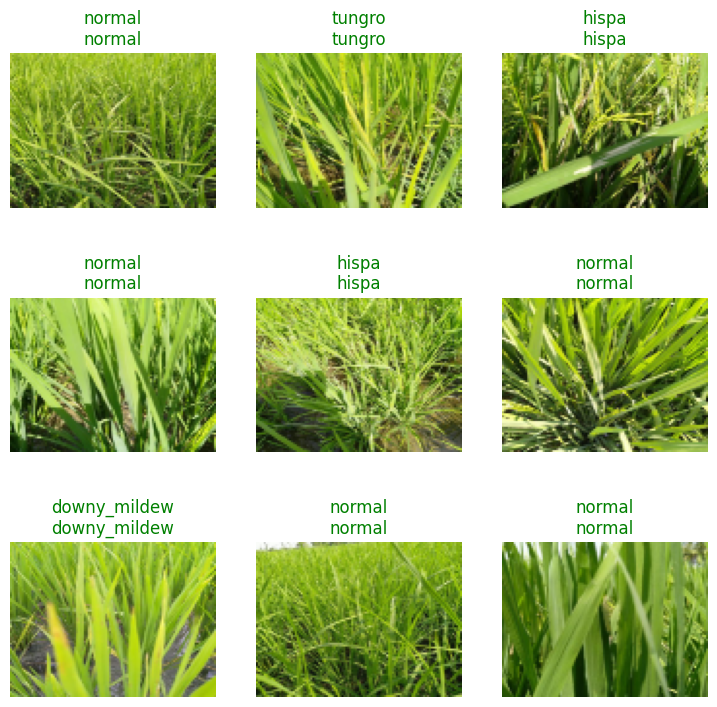

In [156]:
learn.show_results()

In [157]:
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")
desc='size171_120'
learn , lrn_rcd_vals = train(arch,desc=desc, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(171,128), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,1.263001,0.703471,0.232100,0.767900,0.983662,0.778020,0.767900,0.766649,02:04


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,0.630176,0.371039,0.118212,0.881788,0.996636,0.888123,0.881788,0.882448,02:14
1,0.490566,0.328405,0.110524,0.889476,0.997597,0.891779,0.889476,0.888362,02:14
2,0.457224,0.333071,0.104277,0.895723,0.997117,0.898915,0.895723,0.895010,02:12
3,0.342495,0.200757,0.063912,0.936088,0.999039,0.937656,0.936088,0.936454,02:15
4,0.251437,0.156185,0.048534,0.951466,0.999519,0.952705,0.951466,0.951597,02:09
5,0.179550,0.124154,0.038924,0.961076,0.999519,0.961289,0.961076,0.961062,02:14
6,0.127680,0.104313,0.031235,0.968765,0.999519,0.968940,0.968765,0.968711,02:17
7,0.087487,0.084148,0.023546,0.976454,1.000000,0.976512,0.976454,0.976435,02:12
8,0.065839,0.077964,0.022105,0.977895,1.000000,0.977992,0.977895,0.977905,02:15
9,0.052569,0.073598,0.021144,0.978856,1.000000,0.978897,0.978856,0.978852,02:24


In [158]:
shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

'/content/drive/MyDrive/paddy-disease-classification/models/convnext_small_in22k_size171_120.pkl'

In [159]:
# Get and log metrics
train_loss = lrn_rcd_vals[0]
train_loss
valid_loss = lrn_rcd_vals[1]
error_rate_val = lrn_rcd_vals[2]
# Log parameters to MLflow
mlflow.log_param("architecture", arch)
# with mlflow.start_run(nested=True):
mlflow.log_param("batch_aug_size", v_image_size)
mlflow.log_param("batch_aug_min_scale", 0.75)
# with mlflow.start_run(nested=True):
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("valid_loss", valid_loss)
mlflow.log_metric("error_rate", error_rate_val)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


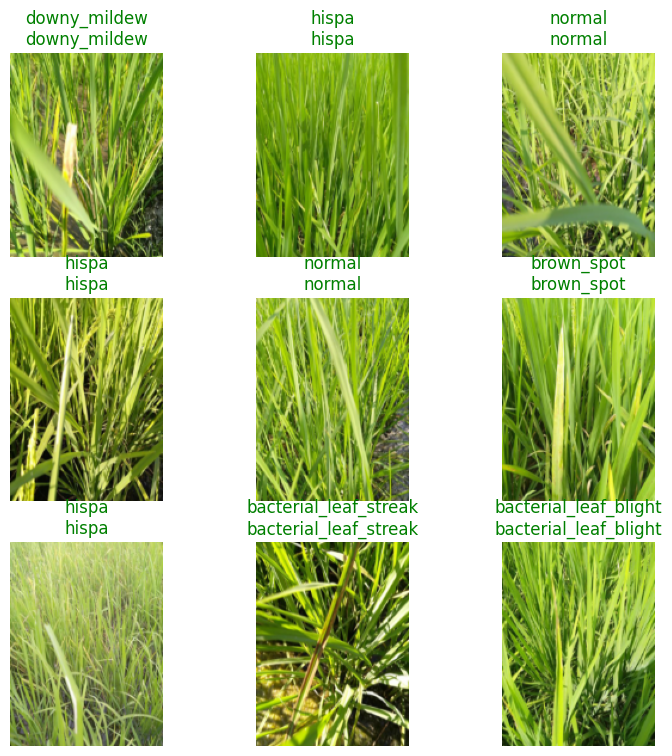

In [160]:
learn.show_results()

In [161]:
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")
desc='size256_192'
learn , lrn_rcd_vals = train(arch, desc=desc, epochs=12, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256,192), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,1.093389,0.642410,0.200865,0.799135,0.985584,0.815173,0.799135,0.801714,02:56


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,precision_score,recall_score,f1_score,time
0,0.501285,0.279578,0.090341,0.909659,0.996636,0.912382,0.909659,0.909436,02:53
1,0.377190,0.227703,0.073042,0.926958,0.998558,0.928668,0.926958,0.926938,02:49
2,0.354617,0.252150,0.074003,0.925997,0.997597,0.926656,0.925997,0.925758,02:52
3,0.293932,0.219164,0.060548,0.939452,0.998558,0.941509,0.939452,0.939831,02:52
4,0.231793,0.163622,0.049976,0.950024,0.999519,0.951394,0.950024,0.950227,02:52
5,0.170266,0.139322,0.045171,0.954829,0.998558,0.956286,0.954829,0.955114,02:51
6,0.139257,0.118802,0.041326,0.958674,0.999519,0.959227,0.958674,0.958657,02:55
7,0.098297,0.108860,0.033638,0.966362,1.000000,0.966724,0.966362,0.966406,02:50
8,0.080903,0.087265,0.024027,0.975973,1.000000,0.976060,0.975973,0.975960,02:51
9,0.054692,0.076387,0.018260,0.981740,1.000000,0.981738,0.981740,0.981702,02:52


In [162]:
shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

'/content/drive/MyDrive/paddy-disease-classification/models/convnext_small_in22k_size256_192.pkl'

In [163]:
# Get and log metrics
train_loss = lrn_rcd_vals[0]
train_loss
valid_loss = lrn_rcd_vals[1]
error_rate_val = lrn_rcd_vals[2]
# Log parameters to MLflow
mlflow.log_param("architecture", arch)
# with mlflow.start_run(nested=True):
mlflow.log_param("batch_aug_size", v_image_size)
mlflow.log_param("batch_aug_min_scale", 0.75)
# with mlflow.start_run(nested=True):
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("valid_loss", valid_loss)
mlflow.log_metric("error_rate", error_rate_val)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


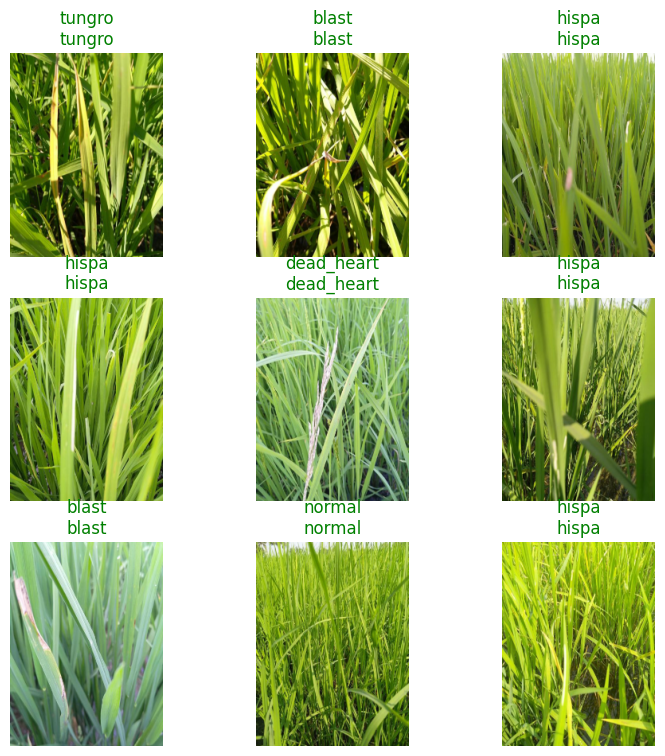

In [164]:
learn.show_results()

In [165]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [166]:
preds,_ = learn.tta(dl=tst_dl)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


In [167]:
idxs = preds.argmax(dim=1)

In [168]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [169]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [170]:
print(f"save_data_drive_path: {save_data_drive_path}")
shutil.copy('subm.csv', f'{save_data_drive_path}/submission.csv')

save_data_drive_path: /content/drive/MyDrive/paddy-disease-classification


'/content/drive/MyDrive/paddy-disease-classification/submission.csv'

In [172]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', desc, competition_name)

100%|██████████| 70.5k/70.5k [00:00<00:00, 74.7kB/s]


In [176]:
if not iskaggle:
    push_notebook('pkappaka3', 'paddydoctor_multimodel_v2.2',
    title='paddy_doctor_multimodel_v3.2',
    file='/content/drive/MyDrive/Colab Notebooks/paddydoctor_multimodel_04.ipynb' ,
    competition=competition_name, private=False, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/pkappaka3/paddy-doctor-multimodel-v3-2


In [ ]:
# Or call cleanup manually when you're done
cleanup()